In [1]:
import numpy as np

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import time
import math
import os

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc. and display plots
from functions import *

In [2]:
np.random.seed(1234)
# set_random_seed(1234)

data_root_dir = "data/kraken/"
n_asset_pairs = 25
n_ss_per_file = 1440
lob_depth = 30
ss_shape = (2*lob_depth, 3)

In [3]:
def read_file_list(data_root_dir, verbose=False):
    updates_file_list = []
    snapshots_file_list = []

    for (dirpath, dirnames, filenames) in os.walk(data_root_dir):
        updates_file_list.extend([dirpath+'/'+filename for filename in filenames if filename != ".DS_Store" and filename[0] == 'u'])
        snapshots_file_list.extend([dirpath+'/'+filename for filename in filenames if filename != ".DS_Store" and filename[0] == 's'])

    updates_file_list = sorted(updates_file_list)
    snapshots_file_list = sorted(snapshots_file_list)
    
    if verbose:
        print(len(snapshots_file_list), "update files read.")
        print(len(updates_file_list), "snapshot files read.")
        
    return updates_file_list, snapshots_file_list

In [4]:
def count_labels(dataset):
    up_cnt = 0
    down_cnt = 0
    nomove_cnt = 0
    for i,data in enumerate(dataset):
        if data["label"] == -1:
            down_cnt += 1
        if data["label"] == 0:
            nomove_cnt += 1
        if data["label"] == 1:
            up_cnt += 1

    print("UP labels:", up_cnt, '\t', '{}%'.format(up_cnt/(up_cnt+nomove_cnt+down_cnt)*100))
    print("NO_MOVE labels:", nomove_cnt, '\t', '{}%'.format(nomove_cnt/(up_cnt+nomove_cnt+down_cnt)*100))
    print("DOWN labels:", down_cnt, '\t', '{}%'.format(down_cnt/(up_cnt+nomove_cnt+down_cnt)*100))

In [5]:
updates_file_list, snapshots_file_list = read_file_list(data_root_dir=data_root_dir, verbose=True)

n_files = len(snapshots_file_list)
n_days = int(n_files / n_asset_pairs)

print(n_days, "days of data is collected.")

30 update files read.
30 snapshot files read.
1 days of data is collected.


# Dataprep

In [11]:
alpha = 0.0015
delay = 100
n_labels = 3

In [12]:
dataset = np.zeros([n_files*n_ss_per_file], 
                   dtype=[('snapshot', np.float32, ss_shape), ('rel_prices', np.float32, 2*lob_depth), ('timestamp', np.float32, 1), ('wamp', np.float32, 1),('label', int, 1)])

global_cnt = 0

for i in range(n_asset_pairs):
    asset_pair_cnt = 0
    
    for j in range(n_days):
        data = np.loadtxt(snapshots_file_list[i*n_days+j], delimiter=',')
        
        for j, ss in enumerate(data):
            snapshot = ss[:-1].reshape(-1, 3)
            timestamp = ss[-1]
            wamp = calc_WAMP(ss)

            dataset[global_cnt]["snapshot"] = snapshot[100-lob_depth:100+lob_depth]
            dataset[global_cnt]["rel_prices"] = [price / wamp for price in snapshot[100-lob_depth:100+lob_depth,0]]
            dataset[global_cnt]["timestamp"] = timestamp
            dataset[global_cnt]["wamp"] = wamp

            # calculate label for the last snapshot for which enough data is provided with this snapshot
            if asset_pair_cnt >= delay:
                mean = np.mean(dataset["wamp"][global_cnt-delay+1:global_cnt+1])
                act_wamp = dataset["wamp"][global_cnt-delay]
                
                if n_labels == 3:
                    if mean - act_wamp < -(act_wamp*alpha):
                        dataset[global_cnt-delay]["label"] = -1

                    elif mean - act_wamp > act_wamp*alpha:
                        dataset[global_cnt-delay]["label"] = 1

                    else:
                        dataset[global_cnt-delay]["label"] = 0
                elif n_labels == 2:
                    if mean < act_wamp:
                        dataset[global_cnt-delay]["label"] = -1
                    else:
                        dataset[global_cnt-delay]["label"] = 1
                else:
                    raise AttributeError()
                    
            asset_pair_cnt += 1
            global_cnt += 1
            
    # set back global_cnt to overwrite not labeled data (last delay number of elements)
    global_cnt = global_cnt-delay

dataset = dataset[:global_cnt]

In [13]:
len(dataset)

33249

In [14]:
count_labels(dataset)

UP labels: 10328 	 31.062588348521757%
NO_MOVE labels: 14231 	 42.8012872567596%
DOWN labels: 8690 	 26.136124394718642%


In [15]:
ups = dataset[np.where(dataset["label"] == 1)]
nomoves = dataset[np.where(dataset["label"] == 0)]
downs = dataset[np.where(dataset["label"] == -1)]

In [16]:
nb_samples = len(dataset)

n_samples_per_label = 5000

valid_split = 0.2

In [17]:
# shuffle
np.random.shuffle(ups)
np.random.shuffle(nomoves)
np.random.shuffle(downs)

In [18]:
# train-valid-test split
train = np.concatenate(
    (ups[0:int(n_samples_per_label*(1-valid_split))], 
     nomoves[0:int(n_samples_per_label*(1-valid_split))], 
     downs[0:int(n_samples_per_label*(1-valid_split))])
)

valid = np.concatenate(
    (ups[int(n_samples_per_label*(1-valid_split)):n_samples_per_label], 
     nomoves[int(n_samples_per_label*(1-valid_split)):n_samples_per_label], 
     downs[int(n_samples_per_label*(1-valid_split)):n_samples_per_label])
)

# input, select prices only
X_train = train['snapshot']
X_valid = valid['snapshot']

# reshape
X_train = X_train.reshape(-1, 3*lob_depth*2)
X_valid = X_valid.reshape(-1, 3*lob_depth*2)

# output
Y_train = train['label']
Y_valid = valid['label']

In [19]:
# number of labels in train set

count_labels(train)

UP labels: 4000 	 33.33333333333333%
NO_MOVE labels: 4000 	 33.33333333333333%
DOWN labels: 4000 	 33.33333333333333%


In [20]:
# number of labels in validation set

count_labels(valid)

UP labels: 1000 	 33.33333333333333%
NO_MOVE labels: 1000 	 33.33333333333333%
DOWN labels: 1000 	 33.33333333333333%


In [21]:
X_train.shape

(12000, 180)

In [22]:
# standard scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# Linear Regression

In [23]:
C = 1e-3

if n_labels == 2:
    logreg = linear_model.LogisticRegression(C=C,solver='lbfgs')
else:
    logreg = linear_model.LogisticRegression(C=C,solver='sag', multi_class='multinomial')
model = logreg.fit(X_train,Y_train)

In [31]:
logreg.score(X_valid,Y_valid)

0.45116666666666666

In [25]:
predictions = logreg.predict(X_valid)

Confusion matrix, without normalization


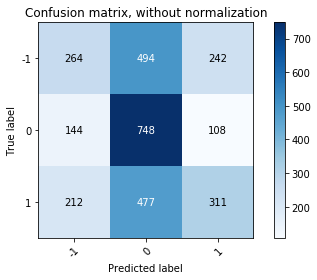

Normalized confusion matrix


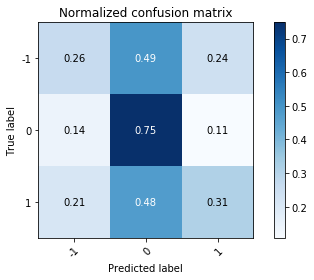

In [26]:
if n_labels == 2:
    class_names = [-1, 1]
elif n_labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_valid, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_valid, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Random Forest

In [27]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
clf.score(X_valid, Y_valid)

0.8873333333333333

In [29]:
predictions=clf.predict(X_valid)

Confusion matrix, without normalization


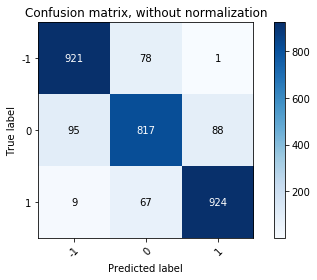

Normalized confusion matrix


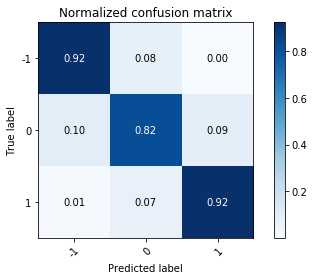

In [30]:
if n_labels == 2:
    class_names = [-1, 1]
elif n_labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_valid, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_valid, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')